In [1]:
pip install pandas matplotlib seaborn scikit-learn

Note: you may need to restart the kernel to use updated packages.


✅ Cleaned Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 7919 entries, 0 to 15507
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      7919 non-null   object 
 1   Year      7919 non-null   int64  
 2   Duration  7919 non-null   float64
 3   Genre     7919 non-null   object 
 4   Rating    7919 non-null   float64
 5   Votes     7919 non-null   int64  
 6   Director  7919 non-null   object 
 7   Actor 1   7919 non-null   object 
 8   Actor 2   7919 non-null   object 
 9   Actor 3   7919 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 680.5+ KB
None

✅ Sample Data:
                                 Name  Year  Duration  \
0  #Gadhvi (He thought he was Gandhi)  2019     109.0   
2                             #Yaaram  2019     110.0   
4                ...Aur Pyaar Ho Gaya  1997     147.0   
5                           ...Yahaan  2005     142.0   
7                  ?: A Question Mark 

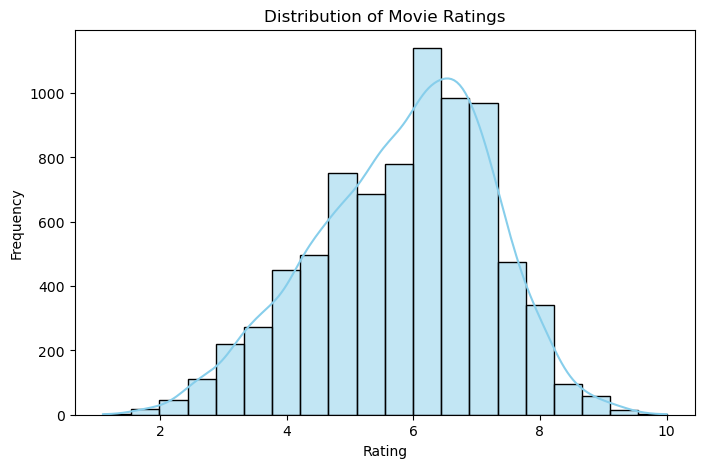

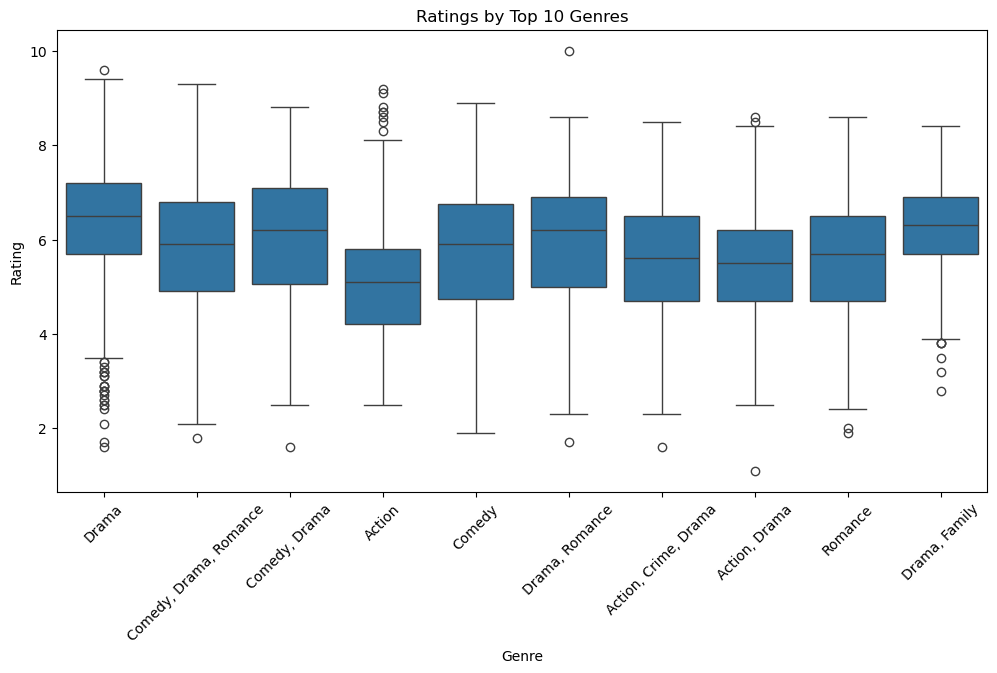

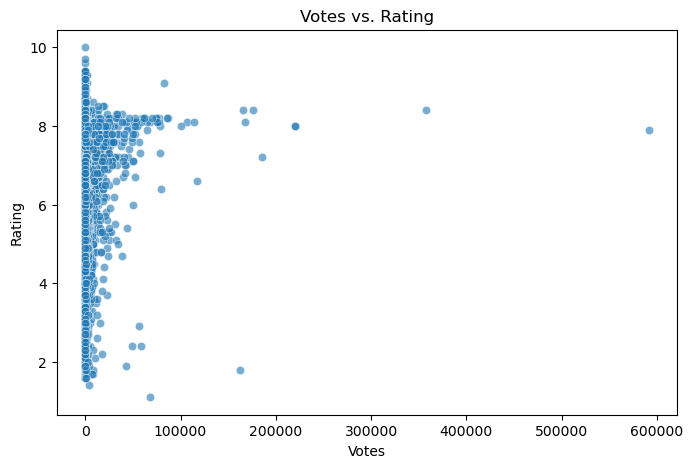

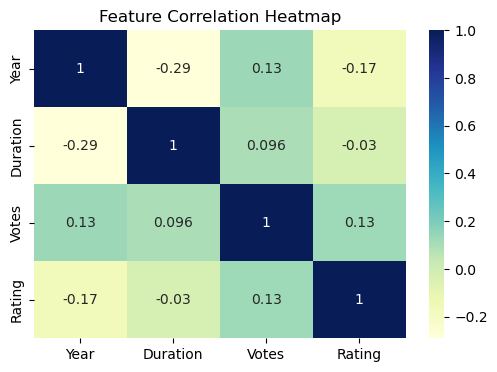


📊 MODEL EVALUATION RESULTS
------------------------------
✅ R² Score       : 0.3258
✅ RMSE (Error)   : 1.1195
------------------------------


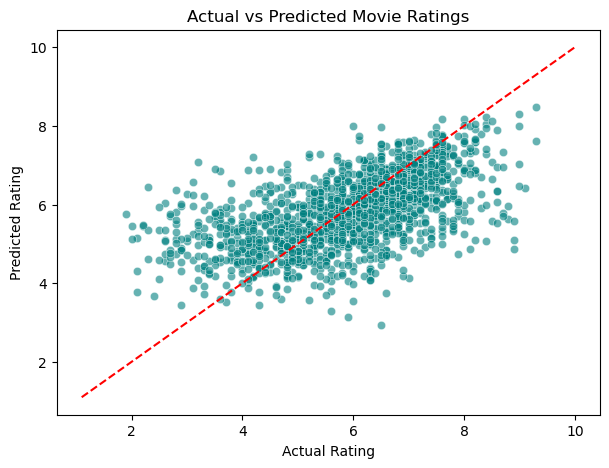

In [5]:
import zipfile
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# ========== 1. Extract and Load ==========
with zipfile.ZipFile("archive (1).zip", 'r') as zip_ref:
    zip_ref.extractall("extracted_data")

csv_path = os.path.join("extracted_data", "IMDb Movies India.csv")
df = pd.read_csv(csv_path, encoding='ISO-8859-1')

# ========== 2. Clean Raw Data ==========
df = df.drop(index=0).reset_index(drop=True)
df = df[df['Rating'].notna()]
df['Year'] = df['Year'].str.extract(r'(\d{4})')
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
df['Votes'] = df['Votes'].str.replace(',', '', regex=False)
df['Votes'] = pd.to_numeric(df['Votes'], errors='coerce')
df['Duration'] = df['Duration'].str.extract(r'(\d+)').astype(float)

for col in ['Year', 'Votes', 'Duration']:
    df[col] = df[col].fillna(df[col].median())

for col in ['Genre', 'Director', 'Actor 1', 'Actor 2', 'Actor 3']:
    df[col] = df[col].fillna("Unknown")

# ========== 3. Preview Clean Data ==========
print("✅ Cleaned Data Info:")
print(df.info())
print("\n✅ Sample Data:")
print(df.head())

# ========== 4. Reduce Cardinality ==========
for col in ['Director', 'Actor 1', 'Actor 2', 'Actor 3']:
    top_items = df[col].value_counts().nlargest(8).index
    df[col] = df[col].apply(lambda x: x if x in top_items else 'Other')

# ========== 5. Visualizations ==========

# Rating Distribution
plt.figure(figsize=(8, 5))
sns.histplot(df['Rating'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

# Boxplot by Top Genres
top_genres = df['Genre'].value_counts().nlargest(10).index
df_top_genres = df[df['Genre'].isin(top_genres)]

plt.figure(figsize=(12, 6))
sns.boxplot(x='Genre', y='Rating', data=df_top_genres)
plt.xticks(rotation=45)
plt.title("Ratings by Top 10 Genres")
plt.show()

# Scatterplot: Votes vs Rating
plt.figure(figsize=(8, 5))
sns.scatterplot(x='Votes', y='Rating', data=df, alpha=0.6)
plt.title('Votes vs. Rating')
plt.xlabel('Votes')
plt.ylabel('Rating')
plt.show()

# Correlation Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(df[['Year', 'Duration', 'Votes', 'Rating']].corr(), annot=True, cmap='YlGnBu')
plt.title('Feature Correlation Heatmap')
plt.show()

# ========== 6. Encode Categorical Data ==========
df_model = df[['Genre', 'Director', 'Actor 1', 'Actor 2', 'Actor 3', 'Year', 'Duration', 'Votes', 'Rating']]
df_encoded = pd.get_dummies(df_model, columns=['Genre', 'Director', 'Actor 1', 'Actor 2', 'Actor 3'], drop_first=True)

# ========== 7. Train-Test Split ==========
X = df_encoded.drop('Rating', axis=1)
y = df_encoded['Rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ========== 8. Train Model ==========
model = RandomForestRegressor(n_estimators=50, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# ========== 9. Evaluate Model ==========
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("\n📊 MODEL EVALUATION RESULTS")
print("-" * 30)
print(f"✅ R² Score       : {r2:.4f}")
print(f"✅ RMSE (Error)   : {rmse:.4f}")
print("-" * 30)

# ========== 10. Prediction vs Actual ==========
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_test, y=y_pred, color='teal', alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual Rating")
plt.ylabel("Predicted Rating")
plt.title("Actual vs Predicted Movie Ratings")
plt.show()